In [1]:
# Use legacy Keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [2]:
import tensorflow as tf
import tensorflow_ranking as tfr
import tensorflow_recommenders as tfrs

from src.tower import Tower
from src.embedding import Embedding
from src.ranking.listwise import ListwiseRanking
from src.utils.utilities import (
    sample_listwise,
    parquet_to_Dataset,
    train_test_split,
    plot_history,
)

RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)

2024-09-03 17:24:44.042345: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 17:24:44.083646: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 17:24:44.083680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 17:24:44.084803: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-03 17:24:44.091124: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 17:24:44.092598: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
# Load ratings dataset
ratings_dataset = parquet_to_Dataset(
    path = 'data/100k-ratings.parquet',
    exclude_columns = ['movie_genres']
)

# Load movies dataset
movies_dataset = parquet_to_Dataset(
    path = 'data/100k-movies.parquet',
    exclude_columns = ['movie_genres']
)

2024-09-03 17:24:46.746726: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-03 17:24:46.747083: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
# Split ratings dataset into train and validation
ratings_trainset, ratings_validset = train_test_split(
    dataset = ratings_dataset,
    train_size = 0.8,
    random_state = RANDOM_STATE,
    buffer_size = 10_000
)

print(f"trainset_size:", ratings_trainset.__len__().numpy())
print(f"validset_size:", ratings_validset.__len__().numpy())

trainset_size: 80000
validset_size: 20000


In [5]:
ratings_trainset = sample_listwise(
    ratings_trainset,
    num_list_per_user=50,
    num_examples_per_list=5,
    seed=RANDOM_STATE
)

ratings_validset = sample_listwise(
    ratings_validset,
    num_list_per_user=1,
    num_examples_per_list=5,
    seed=RANDOM_STATE
)

In [6]:
# Create user embedding
user_embedding_model = Embedding(
    dataset = ratings_trainset.batch(1_000_000),
    str_features = ['user_id', 'user_zip_code', 'user_occupation_text'],
    int_features = ['user_gender', 'bucketized_user_age'],
    text_features = [],
    timestamp_features = ['timestamp'],
    embedding_dim = 32,
)

# Create movie embedding
movie_embedding_model = Embedding(
    dataset = ratings_trainset.batch(1_000),
    str_features = ['movie_title'],
    int_features = [],
    text_features = [],
    timestamp_features = [],
    embedding_dim = 32,
)

In [7]:
candidate_tower = Tower(
    embedding_model = movie_embedding_model,
    dense_layers = []
)

query_tower = Tower(
    embedding_model = user_embedding_model,
    dense_layers = []
)

In [8]:
cached_ratings_trainset = ratings_trainset.shuffle(100_000).batch(8192).cache()
cached_ratings_validset = ratings_validset.batch(4096).cache()

{'root_mean_squared_error': 0.9941517114639282, 'ndcg_metric': 0.9070407152175903, 'loss': 0.9883376359939575, 'regularization_loss': 0, 'total_loss': 0.9883376359939575}


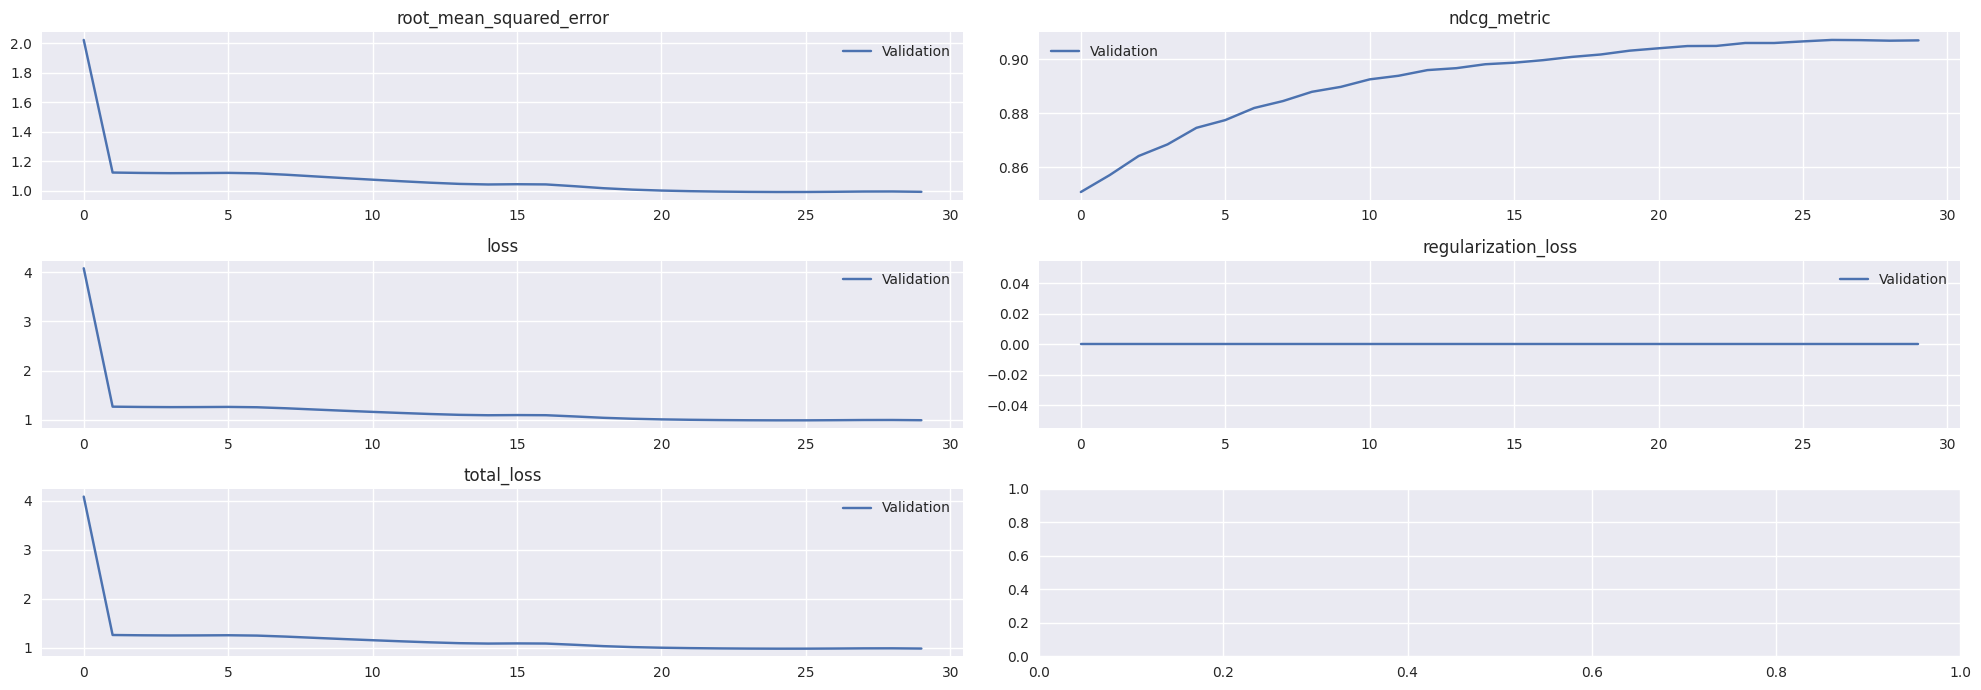

In [9]:
task = tfrs.tasks.Ranking(
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(),
        tfr.keras.metrics.NDCGMetric(name="ndcg_metric"),
    ]
)

model = ListwiseRanking(query_tower, candidate_tower, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history = model.fit(
    cached_ratings_trainset,
    validation_data = cached_ratings_validset,
    validation_freq = 1,
    epochs = 30,
    verbose = False,
)

print(model.evaluate(cached_ratings_validset, return_dict=True, verbose=False))
plot_history(history = history, plot_training=False)

{'root_mean_squared_error': 3.7615487575531006, 'ndcg_metric': 0.9080953001976013, 'loss': 1.0202553272247314, 'regularization_loss': 0, 'total_loss': 1.0202553272247314}


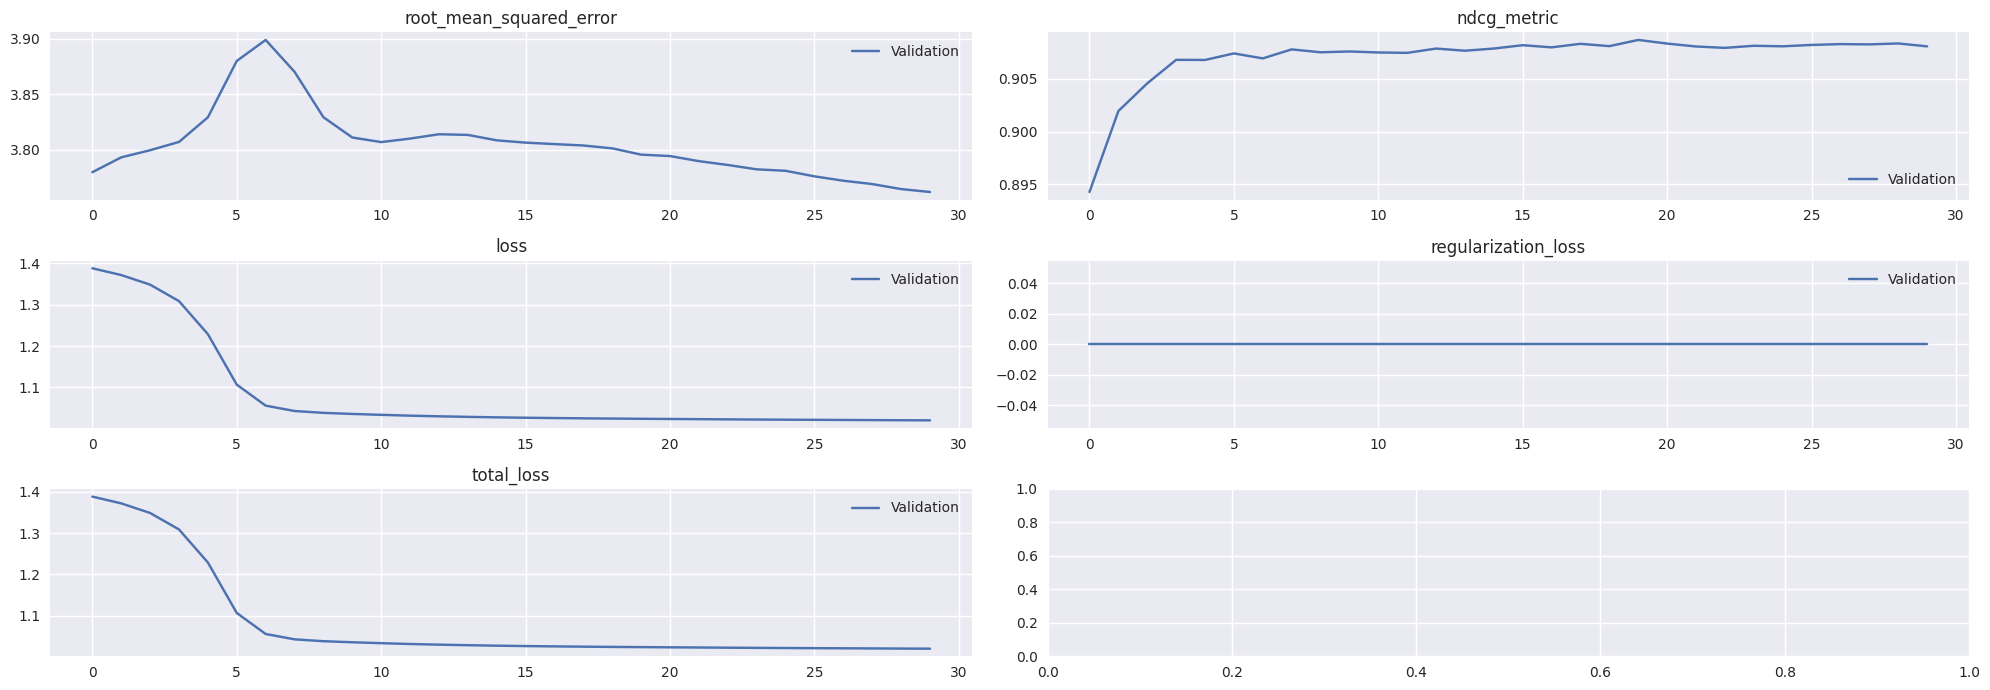

In [10]:
task = tfrs.tasks.Ranking(
    loss = tfr.keras.losses.PairwiseHingeLoss(),
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(),
        tfr.keras.metrics.NDCGMetric(name="ndcg_metric"),
    ]
)

model = ListwiseRanking(query_tower, candidate_tower, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history = model.fit(
    cached_ratings_trainset,
    validation_data = cached_ratings_validset,
    validation_freq = 1,
    epochs = 30,
    verbose = False,
)

print(model.evaluate(cached_ratings_validset, return_dict=True, verbose=False))
plot_history(history = history, plot_training=False)

{'root_mean_squared_error': 4.246104717254639, 'ndcg_metric': 0.908603310585022, 'loss': 4.5327677726745605, 'regularization_loss': 0, 'total_loss': 4.5327677726745605}


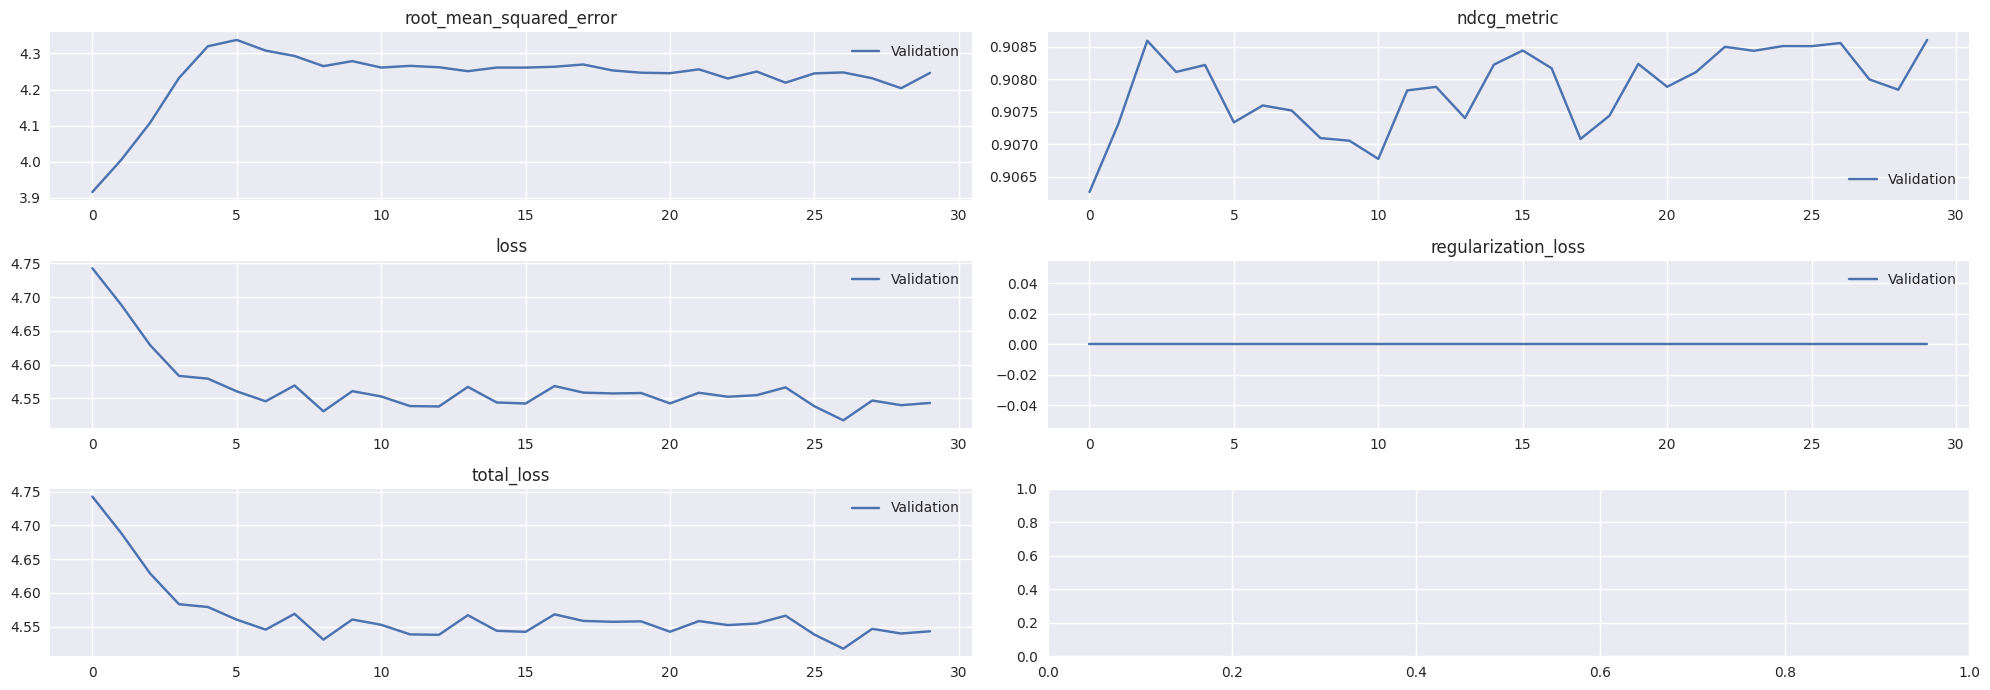

In [11]:
task = tfrs.tasks.Ranking(
    loss = tfr.keras.losses.ListMLELoss(),
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(),
        tfr.keras.metrics.NDCGMetric(name="ndcg_metric"),
    ]
)

model = ListwiseRanking(query_tower, candidate_tower, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history = model.fit(
    cached_ratings_trainset,
    validation_data = cached_ratings_validset,
    validation_freq = 1,
    epochs = 30,
    verbose = False,
)

print(model.evaluate(cached_ratings_validset, return_dict=True, verbose=False))
plot_history(history = history, plot_training=False)